### 4.1 Coding LLM architecture

We specify the configuration of the small GPT-2 model via the following Python dictio-<br>
nary, which we will use in the code examples later:

In [2]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

In [3]:
GPT_CONFIG_124M

{'vocab_size': 50257,
 'context_length': 1024,
 'emb_dim': 768,
 'n_heads': 12,
 'n_layers': 12,
 'drop_rate': 0.1,
 'qkv_bias': False}

#### 4.1 A placeholder for GPT model architecture class

In [4]:
import torch
import torch.nn as nn

class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        self.trf_blocks = nn.Sequential(
                            *[DummyTransformerBlock(cfg)
                                for _ in range(cfg["n_layers"])]) # Use a placeholder for transformer block
        self.final_norm = DummyLayerNorm(cfg["emb_dim"]) # Use a placeholder layernorm
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False) 
        
    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [5]:
class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
    
    def forward(self, x):
        return x
    
class DummyLayerNorm(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        
    def forward(self, x):
        return x

In [6]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [7]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print("Output shape: ", logits.shape)
print(logits)

Output shape:  torch.Size([2, 4, 50257])
tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0448,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
         [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>)


#### 4.2 Normalizing activations with layer normalization

Training deep neural networks with many layers can sometimes prove challenging
due to problems like vanishing or exploding gradients. These problems lead to unsta-
ble training dynamics and make it difficult for the network to effectively adjust its
weights, which means the learning process struggles to find a set of parameters
(weights) for the neural network that minimizes the loss function. In other words, the
network has difficulty learning the underlying patterns in the data to a degree that
would allow it to make accurate predictions or decisions.

The main idea behind `layer normalization` is to adjust the activa-<br>
tions (outputs) of a neural network layer to have a mean of 0 and a variance of 1, also <br>
known as unit variance.

In [8]:
torch.manual_seed(123)
batch_example = torch.randn(2, 5)
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


In [9]:
mean = out.mean(dim=1, keepdim=True)
var = out.var(dim=-1, keepdim=True)
print("Mean: \n", mean)
print("Variance: \n", var)

Mean: 
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance: 
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


In [10]:
out_norm = (out - mean) / torch.sqrt(var)
mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print('Normalized layer output:\n', out_norm)
print('Mean:\n', mean)
print('Variance:\n', var)

Normalized layer output:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[9.9341e-09],
        [1.9868e-08]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [11]:
torch.set_printoptions(sci_mode=False)
print('Mean:\n', mean)
print('Variance:\n', var)

Mean:
 tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


#### A `layer normalization` class

In [12]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))
        
    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

In [13]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, keepdim=True, unbiased=False)
print("Mean: \n", mean)
print("Var: \n", var)

Mean: 
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Var: 
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


#### 4.3 Implement `GLEU` activation

$GLEU(x) = x \mbox{ } \Phi(x)$, where $\Phi(x)$ is the cumulative distribution function <br>
of standard gaussian distribution. In practice its common to implement computationally cheaper option.
\begin{equation}
GELU(x) \approx 0.5 x ( 1 + tanh [ \sqrt{\frac{2}{\pi}} (x + 0.044715 x^{3}) ] )
\end{equation}

In [14]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.44715 * torch.pow(x, 3))
        ))

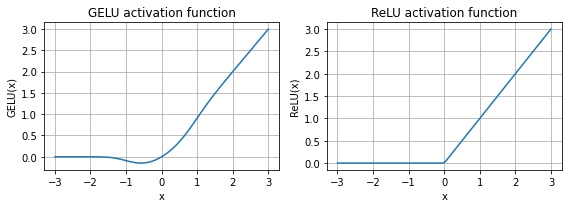

In [15]:
import matplotlib.pyplot as plt
gelu, relu = GELU(), nn.ReLU()

x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)
plt.tight_layout()
plt.show()

#### A feed-forward neural network module

In [16]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"])
        )
        
    def forward(self, x):
        return self.layers(x)

In [17]:
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2, 3, 768)
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


#### 4.4 Adding shortcut (Residual) connections

In [18]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        
        #implement five layers
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]),
                         GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]),
                         GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), 
                         GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), 
                         GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]),
                         GELU())
        ])
    
    def forward(self, x):
        for layer in self.layers:
            layer_output = layer(x)
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x

In [19]:
layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1., 0., -1.]])
torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(layer_sizes, use_shortcut=False)

In [20]:
output = model_without_shortcut(sample_input)

In [21]:
def print_gradients(model, x):
    output = model(x)
    target = torch.tensor([[0.]])
    
    loss = nn.MSELoss()
    loss = loss(output, target)
    loss.backward()
    
    for name, param in model.named_parameters():
        if 'weight' in name:
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

In [22]:
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020471324387472123
layers.1.0.weight has gradient mean of 0.0001231795467901975
layers.2.0.weight has gradient mean of 0.0007344745099544525
layers.3.0.weight has gradient mean of 0.0013871212722733617
layers.4.0.weight has gradient mean of 0.005026495084166527


In [23]:
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=True)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.29920274019241333
layers.1.0.weight has gradient mean of 0.2749510407447815
layers.2.0.weight has gradient mean of 0.45466116070747375
layers.3.0.weight has gradient mean of 0.362958699464798
layers.4.0.weight has gradient mean of 1.763088583946228


In [24]:
from ipynb.fs.full.Chapter_3 import MultiHeadAttention

tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.6983, 1.0865])
Attention weights:  tensor([0.1456, 0.2281, 0.2251, 0.1287, 0.1066, 0.1658])
Sum:  tensor(1.)
Attention weights:  tensor([0.1387, 0.2381, 0.2335, 0.1241, 0.1073, 0.1583])
Sum:  tensor(1.0000)
tensor([0.4416, 0.6508, 0.5687])
tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4561, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.6983, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7069, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3416, 0.6565],
        [0.4561, 0.6983, 0.7069, 0.3416, 0.6605, 0.2855],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2855, 0.9450]])
Attn scores:
 tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4561, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.6983, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7069, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3416, 0.6565],
        [0.4561, 0.6983, 0.7069, 0.3416, 0.6605, 0.2855],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2855, 0.9450]]) 
Attn 

In [25]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg['emb_dim'],
            d_out=cfg['emb_dim'],
            context_length=cfg['context_length'],
            num_heads=cfg['n_heads'],
            dropout=cfg['drop_rate'],
            qkv_bias=cfg['qkv_bias']
        )
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])
        
    
    def forward(self, x):
        
        # Pre-layerNorm is better than post-layernorm
        
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut
        
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut
        return x
        

In [26]:
torch.manual_seed(123)
x = torch.rand(2, 4, 768)
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

print("Input shape: ", x.shape)
print("Output shape: ", output.shape)

Input shape:  torch.Size([2, 4, 768])
Output shape:  torch.Size([2, 4, 768])


### The GPT model architecture implementation

In [27]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )
    
    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        
        pos_embeds = self.pos_emb(
            torch.arange(seq_len, device=in_idx.device)
        )
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

Let’s now initialize the 124-million-parameter GPT model using the `GPT_CONFIG_
124M` dictionary we pass into the `cfg` parameter and feed it with the batch text input
we previously created:

In [28]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

In [29]:
out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape: ", out.shape)
print(out[0].shape)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape:  torch.Size([2, 4, 50257])
torch.Size([4, 50257])


In [30]:
total_params = sum(p.numel() for p in model.parameters())
print(f'Total number of parameters: {total_params:,}')

Total number of parameters: 163,009,536


In [31]:
print("Token embedding layer shape: ", model.tok_emb.weight.shape)
print("Output layer shape: ", model.out_head.weight.shape)

Token embedding layer shape:  torch.Size([50257, 768])
Output layer shape:  torch.Size([50257, 768])


In [32]:
total_params_gpt2 = (
    total_params - sum(p.numel()
                      for p in model.out_head.parameters())
)
print(f"Number of trainable parameters "
      f"considering weight tying: {total_params_gpt2:,}")

Number of trainable parameters considering weight tying: 124,412,160


In [33]:
sum(p.numel() for p in model.trf_blocks.parameters())

85026816

In [34]:
total_size_bytes = total_params * 4
total_size_mb = total_size_bytes / (1024 * 1024)
print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB


## 4.7 Generating text

In [35]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
            
        logits = logits[:, -1, :]
        probas = torch.softmax(logits, dim=-1)
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)
        idx = torch.cat((idx, idx_next), dim=1)
        
    return idx

In [36]:
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print('encoded:', encoded)

encoded: [15496, 11, 314, 716]


In [74]:
encoded_tensor = torch.tensor(encoded).unsqueeze(0)

In [75]:
print('encoded_tensor.shape:', encoded_tensor.shape)

encoded_tensor.shape: torch.Size([1, 4])


In [120]:
model.eval()
out = generate_text_simple(model, encoded_tensor, 6, GPT_CONFIG_124M["context_length"])

In [121]:
out

tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 29739,   554]])

In [131]:
k = model.tok_emb(encoded_tensor)

In [124]:
output = model.out_head(k)

In [130]:
tokenizer.decode(k.squeeze(0).tolist())

' repairing'

In [89]:
output = model(encoded_tensor[:, -GPT_CONFIG_124M["context_length"]:])

In [125]:
logits = output[:, -1, :]

In [126]:
probs = torch.softmax(logits, dim=1)

In [127]:
probs.shape

torch.Size([1, 50257])

In [129]:
k = torch.argmax(probs, dim=-1, keepdim=True)

In [84]:
print("output: ", output)
print("output length: ", len(out[0]))

output:  tensor([[[ 0.1570,  0.3790, -0.1052,  ...,  1.2618,  0.3342,  0.7445],
         [ 0.0330,  0.0517,  0.2529,  ...,  0.4698,  0.1187,  0.9938],
         [ 0.5532,  0.5810, -0.0384,  ...,  1.1717,  0.3839,  0.7470],
         [ 0.1784,  0.7126,  0.7358,  ...,  0.3408,  0.5483,  0.9467]],

        [[ 0.1873,  1.1682,  0.5817,  ...,  0.1806,  0.0093, -0.5668],
         [-0.3046,  0.6550,  0.1793,  ...,  0.3088,  0.4487, -0.0436],
         [ 0.9321,  0.4172,  0.2954,  ...,  0.3836,  0.7352, -0.1030],
         [ 0.5907,  0.5709,  0.3323,  ...,  1.3798,  1.2681,  0.3915]]],
       grad_fn=<AddBackward0>)
output length:  10
